In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Read the CSV files

customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')


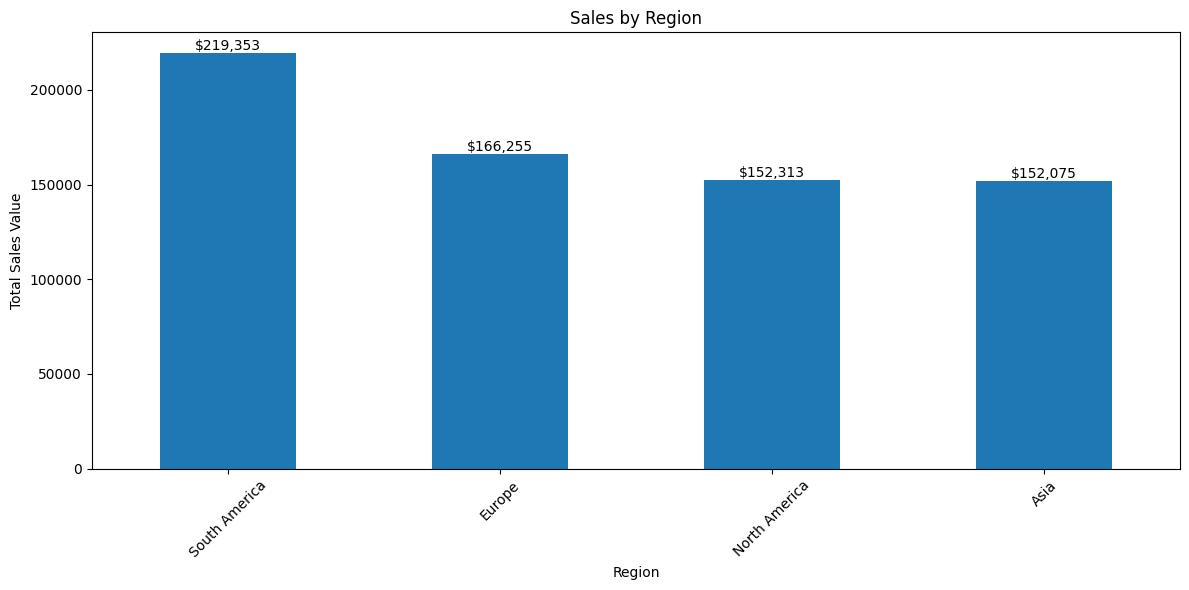


Regional Sales Summary:
               TotalValue
Region                   
South America   219352.56
Europe          166254.63
North America   152313.40
Asia            152074.97


In [ ]:
regional_data = transactions.merge(customers[['CustomerID', 'Region']], on='CustomerID')
regional_sales = regional_data.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = regional_sales.plot(kind='bar')
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales Value')
plt.xticks(rotation=45)
for i, v in enumerate(regional_sales):
    ax.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\nRegional Sales Summary:")
print(regional_sales.to_frame())


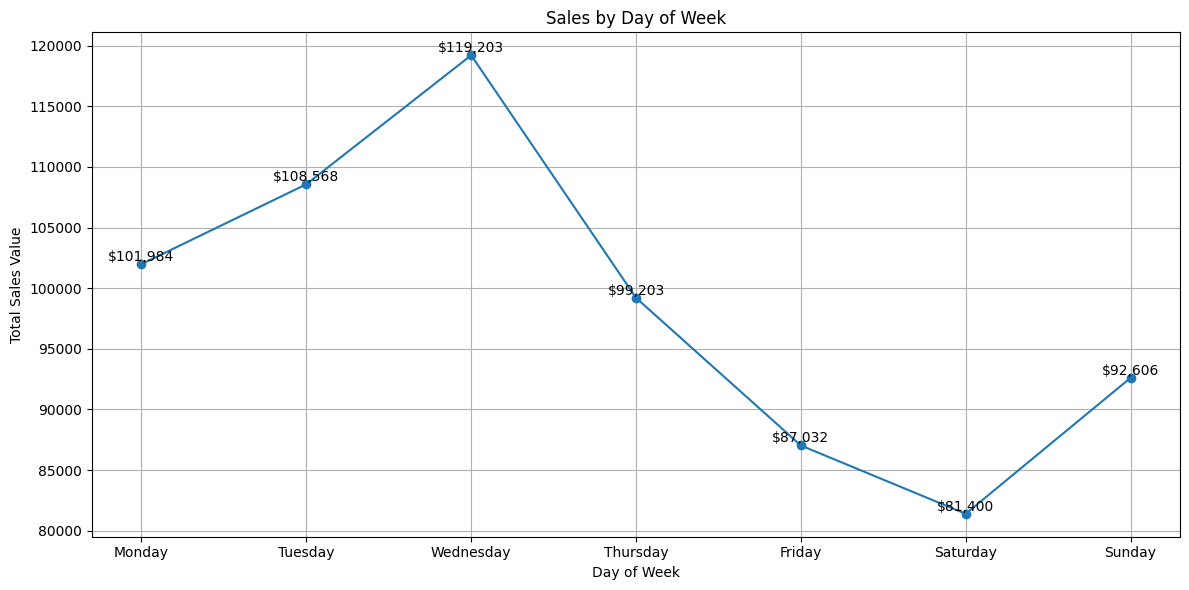


Daily Sales Summary:
           TotalValue
DayOfWeek            
Monday      101984.33
Tuesday     108567.61
Wednesday   119203.15
Thursday     99202.71
Friday       87032.09
Saturday     81399.74
Sunday       92605.93


In [ ]:
transactions['DayOfWeek'] = pd.to_datetime(transactions['TransactionDate']).dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = transactions.groupby('DayOfWeek')['TotalValue'].sum()
daily_sales = daily_sales.reindex(day_order)

plt.figure(figsize=(12, 6))
ax = daily_sales.plot(kind='line', marker='o')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales Value')
plt.grid(True)
for i, v in enumerate(daily_sales):
    ax.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\nDaily Sales Summary:")
print(daily_sales.to_frame())


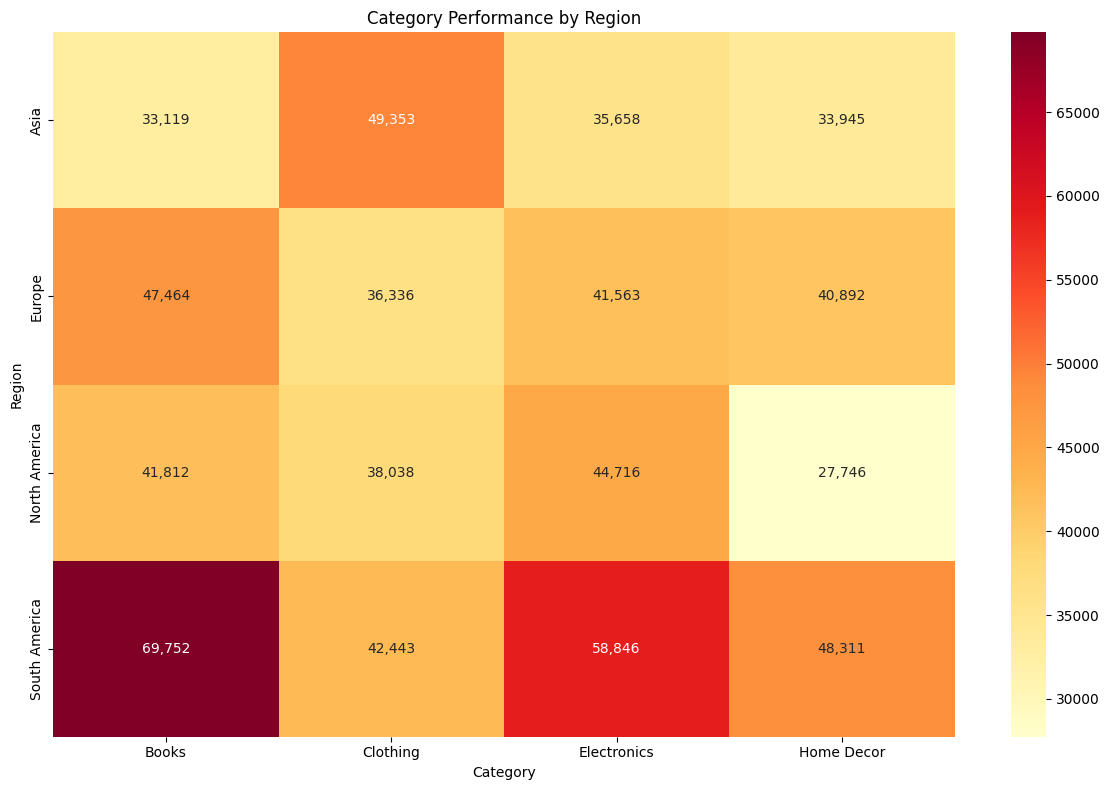


Category-Region Performance:
Category          Books  Clothing  Electronics  Home Decor
Region                                                    
Asia           33119.03  49353.09     35658.15    33944.70
Europe         47464.42  36335.59     41562.60    40892.02
North America  41811.99  38038.49     44716.43    27746.49
South America  69752.03  42443.49     58846.32    48310.72


In [ ]:
# Merge all necessary data
category_region = transactions.merge(customers[['CustomerID', 'Region']], on='CustomerID')
category_region = category_region.merge(products[['ProductID', 'Category']], on='ProductID')

# Create pivot table
pivot_data = pd.pivot_table(
    category_region,
    values='TotalValue',
    index='Region',
    columns='Category',
    aggfunc='sum'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=',.0f', cmap='YlOrRd')
plt.title('Category Performance by Region')
plt.tight_layout()
plt.show()

print("\nCategory-Region Performance:")
print(pivot_data)


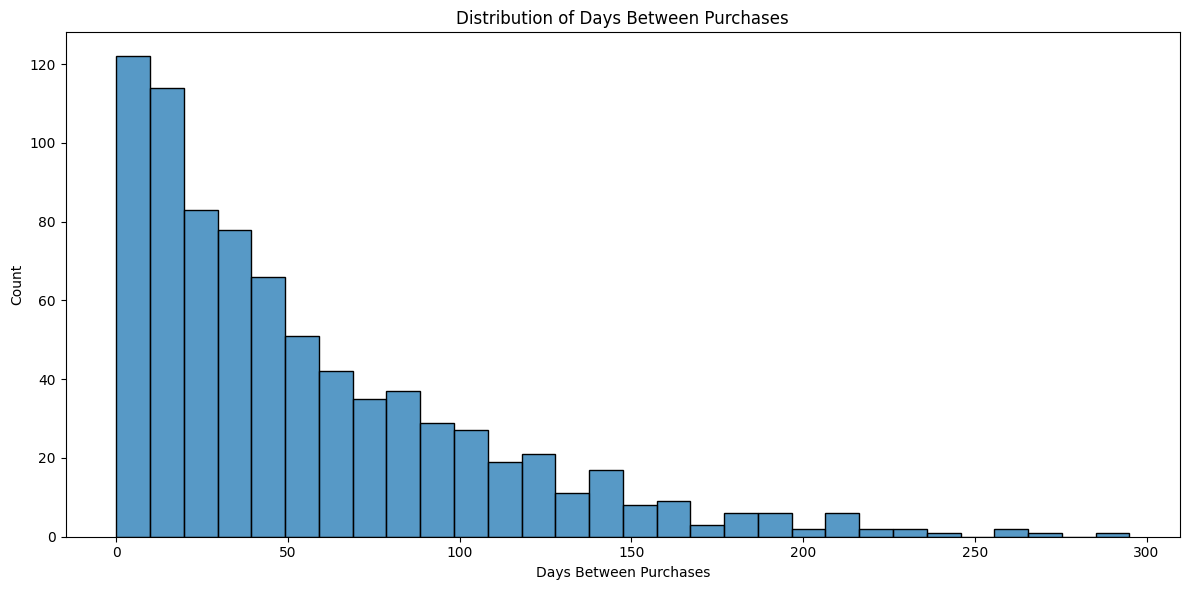


Purchase Frequency Summary:
count    801.000000
mean      55.377029
std       51.014975
min        0.000000
25%       16.000000
50%       40.000000
75%       81.000000
max      295.000000
Name: DaysBetween, dtype: float64


In [ ]:
# Calculate days between purchases for each customer
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customer_purchases = transactions.sort_values(['CustomerID', 'TransactionDate'])
customer_purchases['PrevPurchase'] = customer_purchases.groupby('CustomerID')['TransactionDate'].shift(1)
customer_purchases['DaysBetween'] = (customer_purchases['TransactionDate'] -
                                    customer_purchases['PrevPurchase']).dt.days

plt.figure(figsize=(12, 6))
sns.histplot(data=customer_purchases['DaysBetween'].dropna(), bins=30)
plt.title('Distribution of Days Between Purchases')
plt.xlabel('Days Between Purchases')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nPurchase Frequency Summary:")
print(customer_purchases['DaysBetween'].describe())


<ipython-input-5-d4fd78140c1e>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_performance = price_tier_data.groupby('PriceTier').agg({


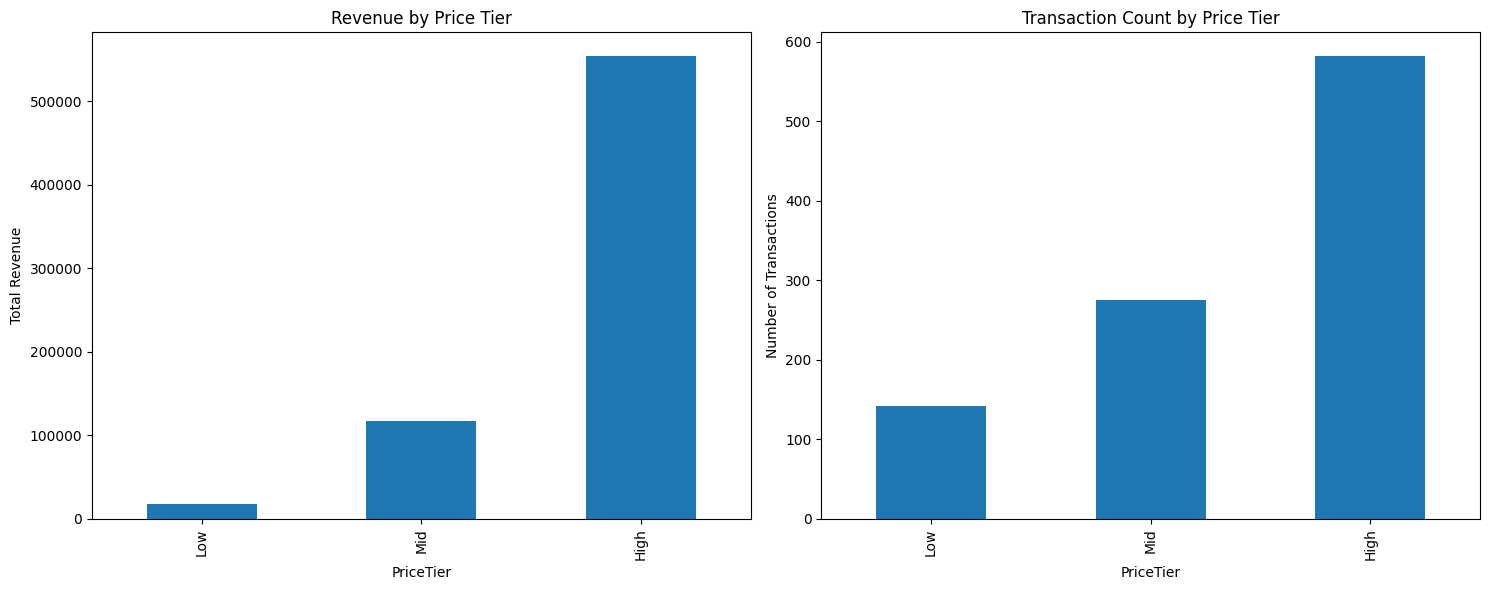

In [ ]:
# Add price tiers to products
products['PriceTier'] = pd.cut(
    products['Price'],
    bins=[0, 100, 250, float('inf')],
    labels=['Low', 'Mid', 'High']
)

# Merge with transactions
price_tier_data = transactions.merge(products[['ProductID', 'PriceTier']], on='ProductID')
tier_performance = price_tier_data.groupby('PriceTier').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'Count'})

# Calculate percentage of transaction counts for each tier
tier_performance['PercentageTransactions'] = (tier_performance['Count'] / tier_performance['Count'].sum()) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue by tier
tier_performance['TotalValue'].plot(kind='bar', ax=ax1)
ax1.set_title('Revenue by Price Tier')
ax1.set_ylabel('Total Revenue')

# Transaction count by tier
tier_performance['Count'].plot(kind='bar', ax=ax2)
ax2.set_title('Transaction Count by Price Tier')
ax2.set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()


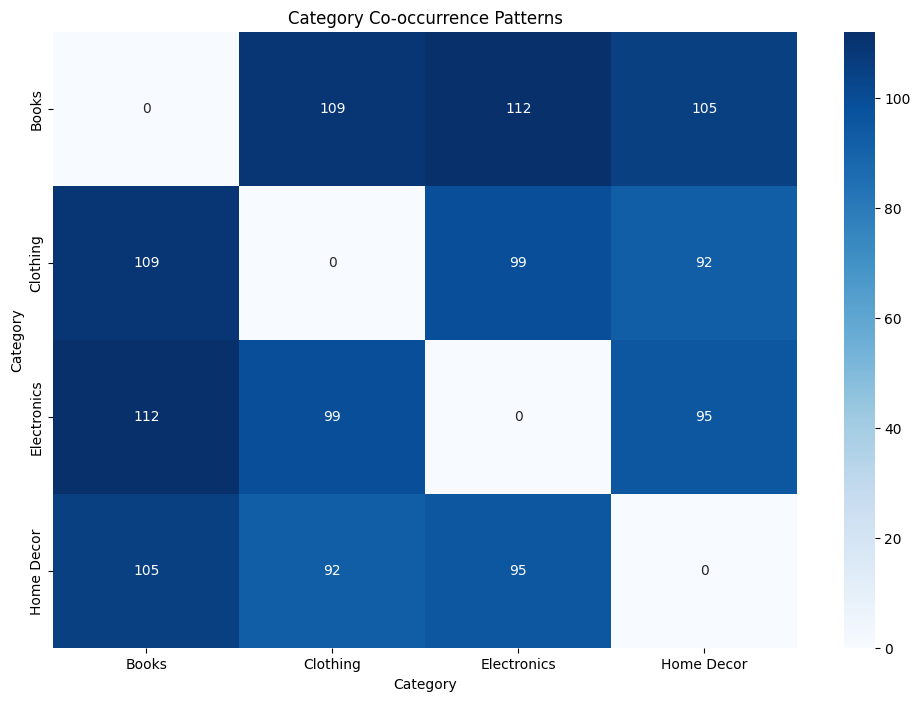

In [ ]:
merged = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
cross_cat = merged.groupby(['CustomerID', 'Category'])['TransactionID'].nunique().unstack().fillna(0)
cross_cat = cross_cat.gt(0).astype(int)
co_occurrence = cross_cat.T.dot(cross_cat)
np.fill_diagonal(co_occurrence.values, 0)

plt.figure(figsize=(12,8))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues")
plt.title('Category Co-occurrence Patterns')
plt.show()